In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, jit, jacobian, vmap
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
import time

In [2]:
# @njit
# def toeplitz(r, c):
#     c = np.asarray(c).ravel()
#     r = np.asarray(r).ravel()
#     # Form a 1-D array containing a reversed c followed by r[1:]
#     # that can be strided to give us toeplitz matrix.
#     vals = np.concatenate((c[::-1], r[1:]))
#     out_shp = len(c), len(r)
#     n = vals.strides[0]
#     return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set up computational parameters (such as computational region)

# set radius of spatial domain
l = 16

# set number of real space grid points
nx = 1025
# real space spatial grid for the purposes of plotting
xvec = np.linspace(-l, l, nx)

# set number of Fourier basis from n = -nF to n = nF
nF = 256
# matrix for converting Fourier basis coefficients into real space
# wave functions by matrix multiplication
nvec = np.arange(-nF, nF + 1)
Fcnvrmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / l) / np.sqrt(2 * l)

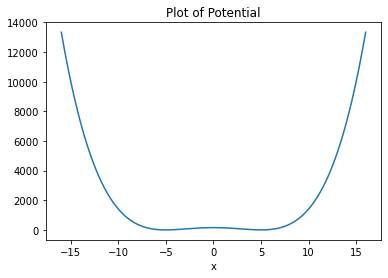

In [4]:
# define potential used to evolve the system

def v(x):
    # dimensionless quantum harmonic oscillator potential
    # return 0.5 * x**2
    # symmetric double well potential
    return 0.25 * (x**2 - 25)**2
    # rescaled symmetric double well potential
    # return 0.0025 * (x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential at xvec real space grid points
# vtruvec = v(xvec)

# plot true potential
plt.plot(xvec, v(xvec))
plt.title('Plot of Potential')
plt.xlabel('x')
plt.show()

In [5]:
# transform potential to Fourier basis

# Fres can be adjusted to improve the Fourier basis resolution
# if we set Fres = 1, then Fsample = 2*nfb, which is the
# Nyquist frequency (which is low quality?)
Fres = 100
Fsample = Fres * 2 * nF
# print(Fsample)
Fxvec = np.linspace(-l, l, Fsample + 2, endpoint=False)
# Fvvec = np.fft.rfft(v(Fxvec), norm='forward')[:(2 * nF + 1)]
# this is what Harish uses
Fvvec = (np.fft.rfft(v(Fxvec)) / Fxvec.size)[:(2 * nF + 1)]

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = Fvvec * (-1)**np.arange(2 * nF + 1)
vmat = sl.toeplitz(r=vrow, c=vrow.conj())

(513,)
(513, 1025)


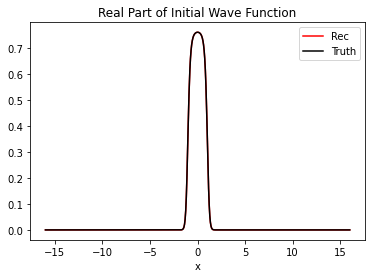

Rel Norm Diff: 4.039895685962957e-09


In [6]:
# define initial state and transform to Fourier basis

# I GET BETTER RESULTS WHEN I USE MY METHOD WHICH NORMALIZES
# THE INITIAL WAVE FUNCTION RATHER THAN USING THE WAVE FUNCTION
# NORMALIZED MANUALLY

def psi0(x):
    # rounded box function
    # return 1.0 + np.tanh((1 - x**2)/0.5)
    # HSB's manually normalized rounded box function
    return (1.0 + np.tanh((1 - x**2)/0.5)) / 2.58046
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))

# def mknormpsifn(psifn):
    # compute psi normalization term,
    # this is a constant given some psi
    # psiprobintegrand = lambda x: np.abs(psifn(x))**2
    # normterm = np.sqrt(si.quad(psiprobintegrand, a=-l, b=l)[0])

    # define function for computing normalized psi
    # via scipy.integrate methods
    # def normpsifn(x):
    #     return psifn(x)/normterm

    # return normpsifn

# normpsi0fn = mknormpsifn(psi0)
normpsi0fn = psi0 # when using Harish's psi0
# vector of the normalized psi0 function sampled on the
# real space grid for plotting
normpsi0vec = normpsi0fn(xvec)

# compute the Fourier basis representation of the
# normalized psi0 function using a scipy.integrate method
normpsi0integrand = lambda x: np.exp(-1j * np.pi * nvec * x / l) / np.sqrt(2 * l) * normpsi0fn(x)
normpsi0quadrtn = si.quad_vec(normpsi0integrand, -l, l)[0]
Fnormpsi0vec = si.quad_vec(normpsi0integrand, -l, l)[0]
print(normpsi0quadrtn.shape)
print(Fcnvrmat.shape)
# Fnormpsi0vecrec2 = normpsi0quadrtn @ Fmat
Fnormpsi0vecrec = normpsi0quadrtn @ Fcnvrmat

# plot the real part of the normalized psi0
plt.plot(xvec, Fnormpsi0vecrec.real, 'r', label="Rec")
plt.plot(xvec, normpsi0vec.real, 'k', label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff:', nl.norm(normpsi0vec - Fnormpsi0vecrec) / nl.norm(normpsi0vec))

In [7]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * l**2))

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
hmat = kmat + vmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(hmat - hmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spc, stts = nl.eigh(hmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(hmat @ stts - stts @ np.diag(spc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(stts @ stts.conj().T - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
2.2881828020590297e-10
Unitary stts check (should be close to zero):
6.637256364934329e-14


In [8]:
# find indices that sort eigenvalues
ordering = np.argsort(spc)

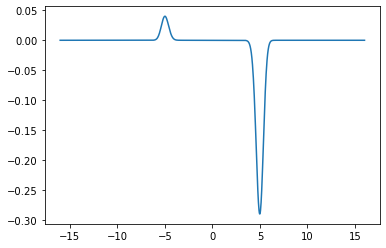

Quick check of Ground state' normalization (should be close to 1):
0.9999999999999984
Check of Ground state' normalization (should be close to 1):
0.9999999999999984


In [9]:
# pick out and plot ground state
groundstate = ordering[0]
wavefn = stts[:,groundstate] @ Fcnvrmat
plt.plot(xvec, -np.real(wavefn))
plt.show()

# quick and dirty check if the ground state wave function
# is normalized
print('Quick check of Ground state\' normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

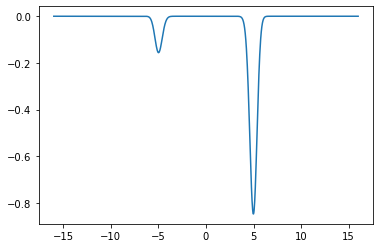

Quick check of Ground state' normalization (should be close to 1):
0.9999999999999992
Check of Ground state' normalization (should be close to 1):
0.9999999999999993


In [10]:
# pick out and plot the j-th state with j starting at 0
wavefn = stts[:,ordering[1]] @ Fcnvrmat
plt.plot(xvec, np.imag(wavefn))
plt.show()

# quick and dirty check if the ground state wave function
# is normalized
print('Quick check of Ground state\' normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

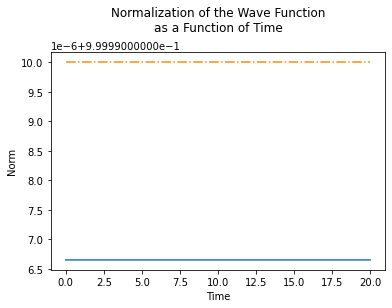

Average Norm of Trajectory (should be close to 1):
0.9999966495230006


In [11]:
# solve the forward problem and generate amat
# set the time step and compute the propagator matrix
# note that we are reusing the spectrum and states from
# the eigendecomposition of Hamiltonian matrix computed above

# set the size of a time step
dt = 0.01

# make the propagator matrix
propamat = stts @ np.diag(np.exp(-1j * spc * dt)) @ stts.conj().T

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
nts = 2000

# propagate the system starting from the initial "a" state
amat = np.zeros((nts + 1, 2 * nF + 1), dtype=np.complex128)
amat[0,:] = Fnormpsi0vec.copy()
for i in range(nts):
    amat[i + 1,:] = propamat @ amat[i,:]

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(amat @ Fcnvrmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nts + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nts + 1), sep='\n')

In [ ]:
# Gaussian basis model of the potential

# the number of Gaussian basis functions equals 2 * J + 1
J = 64

# set the width of the Gaussian basis functions
alpha = 4.0

# real space special grid points which determines
# the location of the centers of the Gaussian basis functions
h = l / J
Gxvec = np.arange(-J, J+1) * h

# Gaussian basis matrix used for transforming the Gaussian
# basis coefficients to real space values located at each
# real space grid point
xvecmesh, Gxvecmesh = np.meshgrid(xvec, Gxvec, sparse=True, indexing='ij')
Gmat = np.exp(-alpha * (xvecmesh - Gxvecmesh)**2)

# vector of k-space terms needed to make the potential
# matrix in the Fourier basis representation from Gaussian basis
# coefficients, also for computing the gradient of the
# potential matrix from the Gaussian basis coefficients
Gkvec = np.pi * np.arange(0, 2 * J + 1) / l

# function which makes the potential matrix in the
# Fourier basis representation from Gaussian basis
# coefficients
@jit
def mkGvmat(cffs):
    Gkvecmesh, Gxvecmesh = np.meshgrid(Gkvec, Gxvec, sparse=True, indexing='ij')
    cnsGFmat = np.exp(-1j * Gkvecmesh * Gxvecmesh)
    cnsexptrm = np.exp(-Gkvecmesh ** 2 / (4 * alpha))
    toeprow = np.sqrt(np.pi / alpha) * cnsexptrm / (2 * l) * (cnsGFmat @ cffs)
    return sl.toeplitz(r=toeprow, c=toeprow.conj())

# gradient of the potential matrix in the Fourier basis
# representation, this is a constant
gradGvmat = np.zeros((2 * J + 1, 2 * nF + 1, 2 * nF + 1), dtype=np.complex128)
for i in range(2 * J + 1):
        thiscffs = np.zeros(2 * J + 1)
        thiscffs[i] = 1
        gradGvmat[i] = mkGvmat(thiscffs)

In [ ]:
@jit
def Gpropa(cffs):
    # construct the Hamiltonian matrix in the Fourier basis
    hmat = kmat + mkGvmat(cffs)

    # eigendecomposition of Hamiltonian matrix
    spc, stts = np.linalg.eigh(hmat)

    # propagator matrix
    propamat = stts @ np.diag( np.exp(-1j * spc * dt) ) @ stts.T.conj()

    # propagate
    amat = np.zeros((nts + 1, 2 * nF + 1), dtype=np.complex128)
    amat[0, :] = np.copy(Fnormpsi0vec)
    for j in range(nts):
        amat[j + 1, :] = propamat @ amat[j, :]

    return spc, stts, amat
